In [52]:
import numpy as np
import pandas as pd
np.set_printoptions(threshold=np.nan)
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
%pylab inline
exec(open("/Users/raghuramkowdeed/Documents/afp/get_signal_names.py").read())
exec(open("/Users/raghuramkowdeed/Documents/afp/portfolio_optimizer.py").read())
import datetime


Populating the interactive namespace from numpy and matplotlib


In [2]:
rps_file = "/Users/raghuramkowdeed/Desktop/afp_data/rps_signals.csv"
signal_data = pd.read_csv(rps_file)


In [3]:
sig_names = [ x.lower() for x in signal_data.columns ]
signal_data.columns = sig_names
signal_data['date'] = pd.Series( [  datetime.datetime.strptime(str(val),'%Y%m%d') 
                                  for val in signal_data['date'].values ], index = signal_data.index  )

signal_data = signal_data.set_index("date")

#signal_data.dropna(how = "any", axis = 1 ,inplace = True)
signal_data.head()

,permno,gvkey,fyear,sic2,spi,mve_f,bm,ep,cashpr,dy,...,baspread,std_dolvol,std_turn,ill,zerotrade,beta,betasq,rsq1,pricedelay,idiovol
date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,10006,1010,1978,37,0.0000,269.308500,1.180962,0.153022,-32.218678,0.067347,...,0.014234,0.881844,0.635898,2.565667e-08,1.115306e-07,1.060404,1.124456,0.343403,0.029861,0.025576
1980-01-31,10057,1098,1978,36,0.0000,97.372000,0.956692,0.135131,-4.408581,0.036982,...,0.022470,1.368363,2.546787,2.719812e-07,6.199128e-08,1.525993,2.328654,0.307902,0.092675,0.037473
1980-01-31,10103,1012,1978,33,NaN,1.697500,3.362003,0.338144,-17.143817,0.000000,...,0.511667,NaN,NaN,NaN,NaN,1.759501,3.095842,0.096756,0.221852,0.087020
1980-01-31,10137,1279,1978,49,NaN,537.524500,1.330341,0.153238,-87.819837,0.137560,...,0.020899,0.553246,0.740017,1.765620e-08,9.726790e-08,0.492885,0.242936,0.189697,0.125795,0.017540
1980-01-31,10145,1300,1978,99,-0.0031,805.633282,1.579284,0.149248,-22.050470,0.070247,...,0.016947,0.427617,0.657563,2.898901e-09,6.190654e-08,1.139150,1.297663,0.279436,0.024234,0.031201


In [4]:
#factor_names = ['beta','mve', 'bm', 'roic', 'agr', 'mom12m']
#all_columns = factor_names[:]
#all_columns.append('ret')

#gls_weights = ['']

In [5]:

def get_factor_returns( dataset, num_stocks,  
                       factor_names ,
                       sig_dir,
                       fac_ret_file,
                       fac_exp_dir,
                       
                      ):
    dates = dataset.index.unique()
    dates = dates.sort_values()
    
    factor_ret_df = pd.DataFrame()
    
    sig_names = get_signal_names()
    
    for dt in dates:
        print(dt)
        this_df = dataset.loc[dt]
        print(this_df.shape)
        sig_df = this_df[sig_names]
        sig_df['ret'] = this_df['ret']
        sig_df.sort_values(by=['mve'], axis=0, ascending =[False], inplace = True)
        sig_df = sig_df.iloc[ 0:min(num_stocks,sig_df.shape[0]), : ]
        sig_df.fillna(sig_df.mean(), inplace=True)
        
        ret = sig_df['ret'].copy()
        sig_df.drop(['ret'], inplace = True, axis=1)

        #require absolute values for portfolio optimizations
        vol = sig_df['idiovol'].copy()
        
        #transforming signal values into ranks and fill na with avg rank.
        #ranking is not applied to ret
        
        sig_rank_df = sig_df.rank(axis=0)*1.0/sig_df.shape[0]
        sig_rank_df['ret'] = ret
        
        
        
        #data required do to cross sectional factor regression and volatility
        #need to decide on adding intercept, normalizing, gls weights exp etc etc.
        
        X = sig_rank_df[factor_names].copy()
        y = ret.copy()
        
        model = LinearRegression(fit_intercept=False)
        model.fit(X,y)
        res_ret = y - np.dot(X,model.coef_)
        sig_rank_df['res_ret'] = res_ret
        
        sig_file = sig_dir + '/' + str( dt.date() ) + '.csv'
        sig_rank_df.to_csv(sig_file)
        
        
        #data requied to construct covariance matrix from this risk model.
        fac_exp_df = X.copy()
        fac_exp_df['vol'] = vol.copy()
        fac_exp_df['ret'] = ret.copy()
        
        fac_exp_file = fac_exp_dir + '/' + str(dt.date()) + '.csv'
        fac_exp_df.to_csv(fac_exp_file)
        
        fac_ret = model.coef_
        fac_ret = pd.Series(fac_ret, index = factor_names, name = dt)
        
        factor_ret_df = factor_ret_df.append(fac_ret)
    factor_ret_df.index.name = 'date'
    factor_ret_df.to_csv(fac_ret_file)
    return factor_ret_df
        

In [6]:
num_stocks = 1000
factor_names =  ['beta','mve', 'bm', 'roic', 'agr', 'mom12m']
sig_dir = '/Users/raghuramkowdeed/Desktop/afp_data/1000/ranked_rps_data/'
fac_exp_dir = '/Users/raghuramkowdeed/Desktop/afp_data/1000/factor_exposure_data/'
fac_ret_file = '/Users/raghuramkowdeed/Desktop/afp_data/1000/fac_ret_file.csv'
arg_dict = { 'dataset':signal_data, 
             'num_stocks':num_stocks,  
             'factor_names':factor_names ,
             'sig_dir':sig_dir,
             'fac_ret_file':fac_ret_file,
             'fac_exp_dir':fac_exp_dir}

In [7]:
factor_ret_df = get_factor_returns( **arg_dict )

1980-01-31 00:00:00
(3482, 149)


/Users/raghuramkowdeed/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/raghuramkowdeed/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1980-02-29 00:00:00
(3482, 149)
1980-03-31 00:00:00
(3519, 149)
1980-04-30 00:00:00
(3512, 149)
1980-05-30 00:00:00
(3529, 149)
1980-06-30 00:00:00
(3550, 149)
1980-07-31 00:00:00
(3576, 149)
1980-08-29 00:00:00
(3623, 149)
1980-09-30 00:00:00
(3755, 149)
1980-10-31 00:00:00
(3735, 149)
1980-11-28 00:00:00
(3731, 149)
1980-12-31 00:00:00
(3741, 149)
1981-01-30 00:00:00
(3741, 149)
1981-02-27 00:00:00
(3730, 149)
1981-03-31 00:00:00
(3725, 149)
1981-04-30 00:00:00
(3711, 149)
1981-05-29 00:00:00
(3710, 149)
1981-06-30 00:00:00
(3713, 149)
1981-07-31 00:00:00
(3707, 149)
1981-08-31 00:00:00
(3726, 149)
1981-09-30 00:00:00
(3809, 149)
1981-10-30 00:00:00
(3790, 149)
1981-11-30 00:00:00
(3804, 149)
1981-12-31 00:00:00
(3821, 149)
1982-01-29 00:00:00
(3815, 149)
1982-02-26 00:00:00
(3838, 149)
1982-03-31 00:00:00
(3861, 149)
1982-04-30 00:00:00
(3858, 149)
1982-05-28 00:00:00
(3873, 149)
1982-06-30 00:00:00
(3888, 149)
1982-07-30 00:00:00
(3884, 149)
1982-08-31 00:00:00
(3930, 149)
1982-09-

In [8]:
#!mkdir /Users/raghuramkowdeed/Desktop/rps_data_dir/

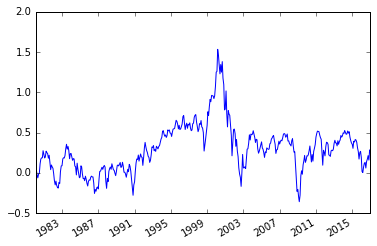

In [9]:
factor_ret_df['beta'].cumsum(axis=0).plot()

In [30]:
factor_ret_df.index.name = 'date'

In [32]:
factor_ret_df.to_csv('/Users/raghuramkowdeed/Desktop/afp_data/1000/fac_ret_file.csv')

In [10]:
dates = signal_data.index.unique()
dates = dates.sort_values()


In [11]:
dates[0].date()

datetime.date(1980, 1, 31)

In [12]:
'agr' in signal_data.columns

True

In [50]:
pm = PortfolioOptimizer(fac_data_dir='/Users/raghuramkowdeed/Desktop/afp_data/1000/factor_exposure_data/',
                        fac_ret_file = '/Users/raghuramkowdeed/Desktop/afp_data/1000/fac_ret_file.csv',
                        fac_cov_hl = 12.0
                       )

1980-01-31.csv
1980-02-29.csv
1980-03-31.csv
1980-04-30.csv
1980-05-30.csv
1980-06-30.csv
1980-07-31.csv
1980-08-29.csv
1980-09-30.csv
1980-10-31.csv
1980-11-28.csv
1980-12-31.csv
1981-01-30.csv
1981-02-27.csv
1981-03-31.csv
1981-04-30.csv
1981-05-29.csv
1981-06-30.csv
1981-07-31.csv
1981-08-31.csv
1981-09-30.csv
1981-10-30.csv
1981-11-30.csv
1981-12-31.csv
1982-01-29.csv
1982-02-26.csv
1982-03-31.csv
1982-04-30.csv
1982-05-28.csv
1982-06-30.csv
1982-07-30.csv
1982-08-31.csv
1982-09-30.csv
1982-10-29.csv
1982-11-30.csv
1982-12-31.csv
1983-01-31.csv
1983-02-28.csv
1983-03-31.csv
1983-04-29.csv
1983-05-31.csv
1983-06-30.csv
1983-07-29.csv
1983-08-31.csv
1983-09-30.csv
1983-10-31.csv
1983-11-30.csv
1983-12-30.csv
1984-01-31.csv
1984-02-29.csv
1984-03-30.csv
1984-04-30.csv
1984-05-31.csv
1984-06-29.csv
1984-07-31.csv
1984-08-31.csv
1984-09-28.csv
1984-10-31.csv
1984-11-30.csv
1984-12-31.csv
1985-01-31.csv
1985-02-28.csv
1985-03-29.csv
1985-04-30.csv
1985-05-31.csv
1985-06-28.csv
1985-07-31

In [35]:
sig_dir = '/Users/raghuramkowdeed/Desktop/afp_data/1000/ranked_rps_data/'

In [36]:
sig_df = pd.DataFrame()
sig_files = os.listdir(sig_dir)
sig_files = np.sort(sig_files)

for sig_file in sig_files :
    if '.csv' not in sig_file :
        continue
    print(sig_file)
    this_file = sig_dir + sig_file
    this_df = pd.read_csv(this_file, index_col = 'date')
    this_df.index = [ datetime.datetime.strptime(val, '%Y-%m-%d') for val in this_df.index]
    sig_df = sig_df.append(this_df)


1980-01-31.csv
1980-02-29.csv
1980-03-31.csv
1980-04-30.csv
1980-05-30.csv
1980-06-30.csv
1980-07-31.csv
1980-08-29.csv
1980-09-30.csv
1980-10-31.csv
1980-11-28.csv
1980-12-31.csv
1981-01-30.csv
1981-02-27.csv
1981-03-31.csv
1981-04-30.csv
1981-05-29.csv
1981-06-30.csv
1981-07-31.csv
1981-08-31.csv
1981-09-30.csv
1981-10-30.csv
1981-11-30.csv
1981-12-31.csv
1982-01-29.csv
1982-02-26.csv
1982-03-31.csv
1982-04-30.csv
1982-05-28.csv
1982-06-30.csv
1982-07-30.csv
1982-08-31.csv
1982-09-30.csv
1982-10-29.csv
1982-11-30.csv
1982-12-31.csv
1983-01-31.csv
1983-02-28.csv
1983-03-31.csv
1983-04-29.csv
1983-05-31.csv
1983-06-30.csv
1983-07-29.csv
1983-08-31.csv
1983-09-30.csv
1983-10-31.csv
1983-11-30.csv
1983-12-30.csv
1984-01-31.csv
1984-02-29.csv
1984-03-30.csv
1984-04-30.csv
1984-05-31.csv
1984-06-29.csv
1984-07-31.csv
1984-08-31.csv
1984-09-28.csv
1984-10-31.csv
1984-11-30.csv
1984-12-31.csv
1985-01-31.csv
1985-02-28.csv
1985-03-29.csv
1985-04-30.csv
1985-05-31.csv
1985-06-28.csv
1985-07-31

In [38]:
sig_name = 'cashdebt'
this_sig_sr = sig_df[sig_name]


In [40]:
begin_date = datetime.datetime.strptime('19900101', '%Y%m%d')
end_date = datetime.datetime.strptime('20170101', '%Y%m%d')

In [42]:
this_sig_sr = this_sig_sr[ (this_sig_sr.index>=begin_date) & (this_sig_sr.index<end_date)]

In [70]:
exec(open("/Users/raghuramkowdeed/Documents/afp/portfolio_optimizer.py").read())


In [71]:

pm = PortfolioOptimizer(fac_data_dir='/Users/raghuramkowdeed/Desktop/afp_data/1000/factor_exposure_data/',
                        fac_ret_file = '/Users/raghuramkowdeed/Desktop/afp_data/1000/fac_ret_file.csv',
                        fac_cov_hl = 12.0
                       )



--------


In [72]:
pnl_sr_1 = pm.run_signal(sig_sr=this_sig_sr,neu_sig=False)
pnl_sr_2 = pm.run_signal(sig_sr=this_sig_sr,neu_sig=True)

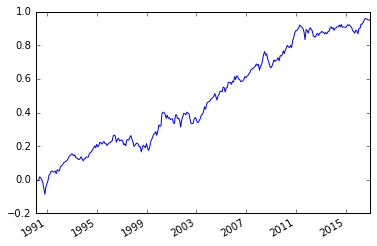

In [73]:
pnl_sr_1.cumsum().plot()

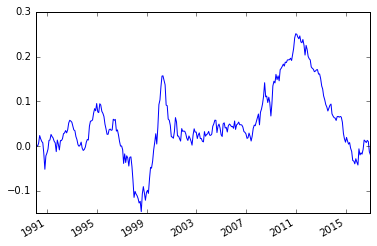

In [74]:
pnl_sr_2.cumsum().plot()

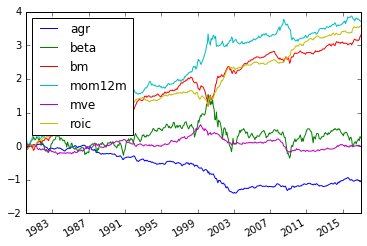

In [75]:
pm.fac_ret.cumsum().plot()